<div style="background-color: darkred; padding: 10px; color: white;">

# Train Soma Classifier

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Load Training Data
    
</div>

### Imports

In [1]:
from random import sample

import ast
import os

from aind_exaspim_soma_detection.utils import img_util, util
from aind_exaspim_soma_detection.training import data_handling
from aind_exaspim_soma_detection.training.data_handling import SomaDataset

%matplotlib inline

### Initializations

In [2]:
# Parameters
anisotropy = [0.748, 0.748, 1.0]
multiscale = 2
patch_shape = (64, 64, 64)

# Paths
img_lookup_path =  "/root/capsule/data/exaspim_image_prefixes.json"
smartsheet_path = "/root/capsule/data/Neuron_Reconstructions.xlsx"
exaspim_soma_path = "/root/capsule/data/exaspim_somas_2024"


### Load Data

In [3]:
# SmartSheet Data
smartsheet_data = data_handling.fetch_smartsheet_somas(
    smartsheet_path,
    img_lookup_path,
    multiscale=multiscale,
)

# ExaSPIM Data
exapsim_data = data_handling.fetch_exaspim_somas_2024(
    exaspim_soma_path,
    img_lookup_path,
    multiscale=multiscale,
)

# Test Examples
test_positives = data_handling.load_test_examples("/root/capsule/data/test_positives.txt")
test_negatives = data_handling.load_test_examples("/root/capsule/data/test_negatives.txt")


/opt/conda/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Create Dataset

In [4]:
# Initialize Dataset
soma_dataset = SomaDataset(patch_shape, transform=True)
for example_tuple in smartsheet_data + exapsim_data:
    soma_dataset.ingest_examples(*example_tuple)

# Remove test examples
for example in test_positives + test_negatives:
    soma_dataset.remove_example(example)

# Report Dataset Specs
print("# Examples:", len(soma_dataset))
print("# Positive Examples", soma_dataset.n_positives())
print("# Negative Examples", soma_dataset.n_negatives())


# Examples: 1971
# Positive Examples 1253
# Negative Examples 718


### Visualize Training Example

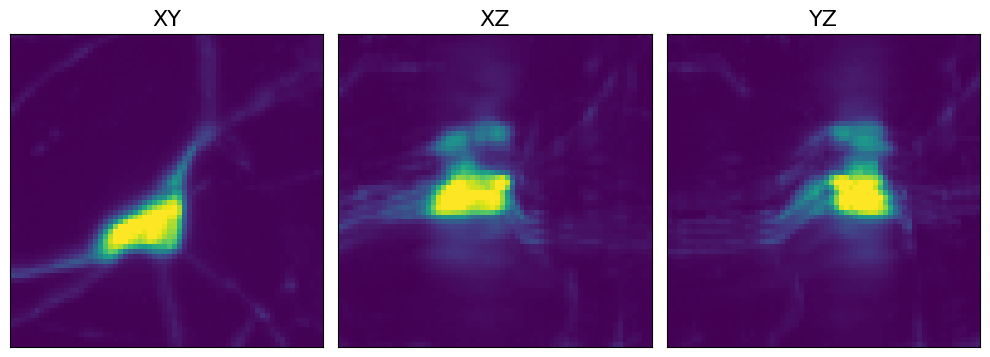

In [5]:
key = util.sample_once(soma_dataset.examples.keys())
soma_dataset.visualize_example(key)

### Visualize Augmented Training Example

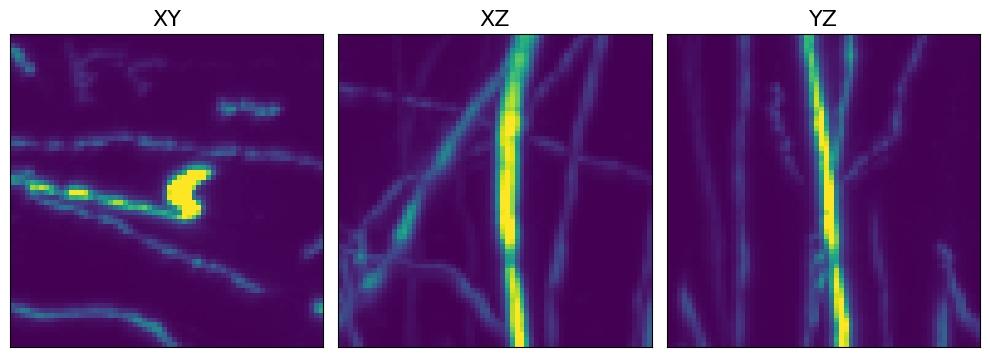

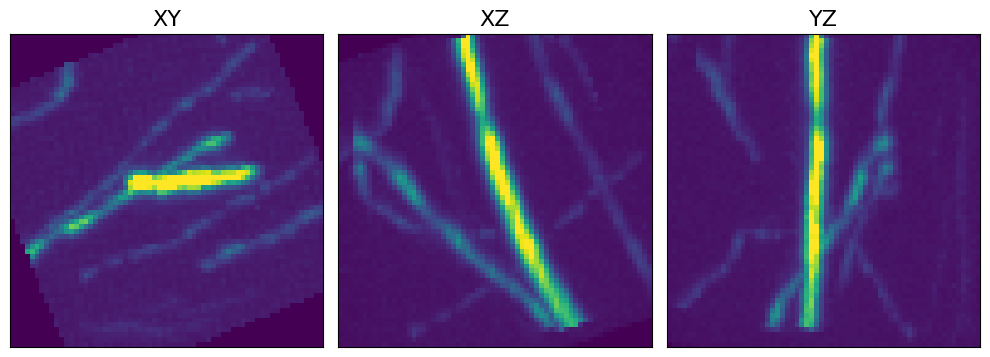

In [6]:
key = util.sample_once(soma_dataset.examples.keys())
soma_dataset.visualize_augmented_example(key)

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Train Model
    
</div>

### Imports

In [7]:
from datetime import datetime

from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from aind_exaspim_soma_detection.training import trainer
from aind_exaspim_soma_detection.training.data_handling import MultiThreadedDataLoader
from aind_exaspim_soma_detection.training.models import Fast3dCNN
from aind_exaspim_soma_detection.utils import ml_util

### Initialize Datasets

In [8]:
# Train-Validation Split - Negative examples
train_negatives, valid_negatives = ml_util.split_train_validation(
    soma_dataset.get_negatives()
)

# Train-Validation Split - Positive examples
n_negatives = len(train_negatives) + len(valid_negatives)
positives_keys = sample(soma_dataset.get_positives().keys(), n_negatives)
positive_examples = dict({k: soma_dataset.examples[k] for k in positives_keys})
train_positives, valid_positives = ml_util.split_train_validation(
    positive_examples
)

# Train-Validation Datasets
train_soma_dataset = data_handling.init_subdataset(
    soma_dataset, train_positives, train_negatives, patch_shape, True
)
valid_soma_dataset = data_handling.init_subdataset(
    soma_dataset, valid_positives, valid_negatives, patch_shape, False
)

### Training Loop

In [9]:
# Parameters
batch_size = 32
lr = 1e-4
lr_gamma = 0.8
lr_step_size = 10
n_epochs = 100

# Paths
model_dir = f"/root/capsule/results/soma_classifiers_{datetime.now()}"
util.mkdir(model_dir)

# Initializations
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Fast3dCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
writer = SummaryWriter()

train_dataloader = MultiThreadedDataLoader(train_soma_dataset, batch_size)
valid_dataloader = MultiThreadedDataLoader(valid_soma_dataset, batch_size)
train_total = len(train_soma_dataset) // batch_size
valid_total = len(valid_soma_dataset) // batch_size

# updates 
# -- try adamw
# -- change scheduler to cosine schedule
# -- also look into schedule free work from neurips

# Main
model.to(device)
n_updates = 0
best_f1 = 0
for epoch in range(n_epochs):
    # Train model
    model.train()
    y, hat_y = list(), list()
    for i, (x_i, y_i) in tqdm(enumerate(train_dataloader), total=train_total):
        # Forward pass
        x_i, y_i = x_i.to(device), y_i.to(device)
        hat_y_i = model(x_i)
        loss = criterion(hat_y_i, y_i)
        writer.add_scalar("loss", loss, n_updates)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_updates += 1

        # Store prediction
        y.append(np.array(y_i.detach().cpu()))
        hat_y.append(np.array(hat_y_i.detach().cpu()))

    y = np.vstack(y)
    hat_y = (np.vstack(hat_y) > 0).astype(int)
    trainer.evaluation_metrics(epoch, writer, y, hat_y, prefix="train")

    # Validate model
    model.eval()
    y, hat_y = list(), list()
    for i, (x_i, y_i) in tqdm(enumerate(valid_dataloader), total=valid_total):
        # Forward pass
        x_i = x_i.to(device)
        hat_y_i = model(x_i)

        y.append(np.array(y_i))
        hat_y.append(np.array(hat_y_i.detach().cpu()))

    # Compute performance metrics
    y = np.vstack(y) 
    hat_y = (np.vstack(hat_y) > 0).astype(int)
    f1 = trainer.evaluation_metrics(epoch, writer, y, hat_y, prefix="validation")

    if f1 > best_f1:
        best_f1 = f1
        model_path = os.path.join(model_dir, f"model_{n_updates}_f1={round(f1, 4)}.pth")
        torch.save(model.state_dict(), model_path)
        print("New Best Model:", model_path)

    # Step the scheduler
    scheduler.step()

 58%|█████▊    | 22/38 [01:01<00:44,  2.80s/it]


KeyboardInterrupt: 